## Import Dependencies

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import pandas as pd
from bayes_opt import BayesianOptimization
from tqdm import tqdm

## Download the taxi-v3 gym class 

In [2]:
taxi = gym.make('Taxi-v3')
state = taxi.reset()
taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



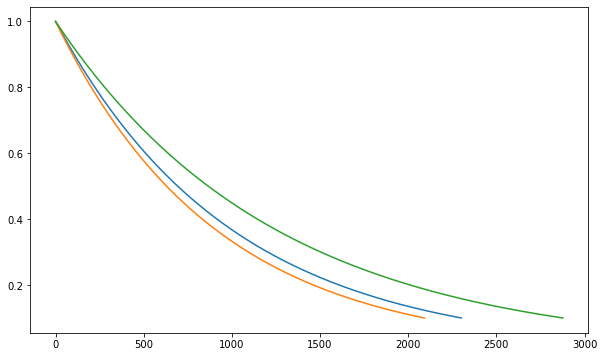

In [3]:
plt.figure(figsize=(10, 6))

def epsilon_decay_graph(epsilon_decay):
    epsilon = 1
    epsilon_array = []
    min_epsilon = 0.1

    while epsilon > min_epsilon:
        epsilon_array.append(epsilon)
        epsilon *= epsilon_decay
    
    plt.plot(epsilon_array)

epsilon_decay_graph(0.999)
epsilon_decay_graph(0.9989)
epsilon_decay_graph(0.9992)

In [4]:
def epsilon_greedy_action(table, state, epsilon):
    action_probs = np.asarray([epsilon / taxi.nA] * taxi.nA, dtype = np.float)
    greedy_action_index = np.argmax(table.loc[state].values)
    action_probs[greedy_action_index] += (1 - epsilon)
    return np.random.choice(range(taxi.nA), p=action_probs)

In [5]:
def Qlearn_estimated_returns_function(n_episodes, alpha = 0.1, gamma = 0.9, epsilon_decay = 0.999, min_epsilon = 0.1):
    ESTIMATED_RETURNS_TBL = pd.DataFrame.from_dict({s: {a: 0 for a in range(taxi.nA)} for s in range(taxi.nS)}, orient='index')
    epsilon = 1

    #for i in tqdm(range(n_episodes))):
    for i in range(n_episodes):
        s0 = taxi.reset()
        epsilon = max(epsilon, min_epsilon)
        estimated_returns = ESTIMATED_RETURNS_TBL
        estimated_returns_copy = ESTIMATED_RETURNS_TBL.copy()
        done = False

        while not done:
            a0 = epsilon_greedy_action(estimated_returns, s0, epsilon)
            s1, reward, done, prob_dict = taxi.step(a0)
            estimated_returns.loc[s0, a0] += alpha * (reward + gamma * estimated_returns.loc[s1].max() - estimated_returns.loc[s0, a0])
            s0 = s1

        epsilon *= epsilon_decay

    return ESTIMATED_RETURNS_TBL

In [6]:
def return_averge_reward(table, episodes):
    average_reward = 0

    for i in tqdm(range(episodes)):
        s0 = taxi.reset()
        done = False
        total_reward = 0

        while not done:
            a0 = np.argmax(table.loc[s0].values)
            s1, reward, done, prob_dict = taxi.step(a0)
            total_reward += reward
            if (reward == -10):
                assert 'illegal step taken, train more'
            #taxi.render()
            s0 = s1
        
        average_reward += total_reward

    return average_reward/episodes

In [7]:
def optimizer_fn(alpha, gamma, epsilon_decay, min_epsilon):
    estimated_returns = Qlearn_estimated_returns_function(3000, alpha=alpha, gamma=gamma, epsilon_decay=epsilon_decay, min_epsilon=min_epsilon)
    return return_averge_reward(estimated_returns, 1000)

pbounds = {'alpha': (0.1, 0.5), 'gamma': (0.5, 0.9), 'min_epsilon': (0.01, 0.1), 'epsilon_decay': (0.9985, 0.9995)}
optimizer = BayesianOptimization(
    f=optimizer_fn,
    pbounds=pbounds,
    random_state=47
)

optimizer.maximize(
    init_points=3,
    n_iter=15
)

|   iter    |  target   |   alpha   | epsilo... |   gamma   | min_ep... |
-------------------------------------------------------------------------
100%|██████████| 1000/1000 [00:01<00:00, 556.16it/s]
|  1        |  5.611    |  0.1454   |  0.9995   |  0.7915   |  0.04163  |
100%|██████████| 1000/1000 [00:01<00:00, 723.58it/s]
|  2        |  7.764    |  0.383    |  0.9993   |  0.7582   |  0.04731  |
100%|██████████| 1000/1000 [00:03<00:00, 312.89it/s]
|  3        | -8.39     |  0.3824   |  0.9987   |  0.6024   |  0.01216  |
100%|██████████| 1000/1000 [00:02<00:00, 429.00it/s]
|  4        |  6.21     |  0.4805   |  0.9985   |  0.6847   |  0.09295  |
100%|██████████| 1000/1000 [00:02<00:00, 373.83it/s]
|  5        | -5.242    |  0.3541   |  0.9992   |  0.5608   |  0.09363  |
100%|██████████| 1000/1000 [00:01<00:00, 609.77it/s]
|  6        |  7.288    |  0.4631   |  0.999    |  0.8019   |  0.1      |
100%|██████████| 1000/1000 [00:02<00:00, 389.10it/s]
|  7        |  6.148    |  0.3742   |

In [8]:
print(optimizer.max)

{'target': 8.035, 'params': {'alpha': 0.3980230898823873, 'epsilon_decay': 0.9990503061045908, 'gamma': 0.8584786246532858, 'min_epsilon': 0.013744631104758352}}


In [9]:
def return_reward_array(table, episodes):
    reward_array = np.zeros(episodes)

    for i in tqdm(range(episodes)):
        s0 = taxi.reset()
        done = False
        total_reward = 0

        while not done:
            a0 = np.argmax(table.loc[s0].values)
            s1, reward, done, prob_dict = taxi.step(a0)
            total_reward += reward
            if (reward == -10):
                assert 'illegal step taken, train more'
            #taxi.render()
            s0 = s1
        
        print('total_reward: {}'.format(total_reward))
        reward_array[i] = total_reward

    return reward_array

  6%|▌         | 60/1000 [00:00<00:01, 588.54it/s]total_reward: 9
total_reward: 8
total_reward: 9
total_reward: 7
total_reward: 10
total_reward: 10
total_reward: 5
total_reward: 10
total_reward: 9
total_reward: 9
total_reward: 7
total_reward: 8
total_reward: 5
total_reward: 10
total_reward: 12
total_reward: 3
total_reward: 8
total_reward: 8
total_reward: 5
total_reward: 8
total_reward: 6
total_reward: 13
total_reward: 10
total_reward: 11
total_reward: 7
total_reward: 10
total_reward: 4
total_reward: 10
total_reward: 8
total_reward: 9
total_reward: 6
total_reward: 6
total_reward: 11
total_reward: 7
total_reward: 7
total_reward: 8
total_reward: 7
total_reward: 11
total_reward: 9
total_reward: 5
total_reward: 10
total_reward: 9
total_reward: 6
total_reward: 10
total_reward: 9
total_reward: 6
total_reward: 11
total_reward: 4
total_reward: 7
total_reward: 12
total_reward: 9
total_reward: 5
total_reward: 8
total_reward: 6
total_reward: 3
total_reward: 9
total_reward: 12
total_reward: 9
total

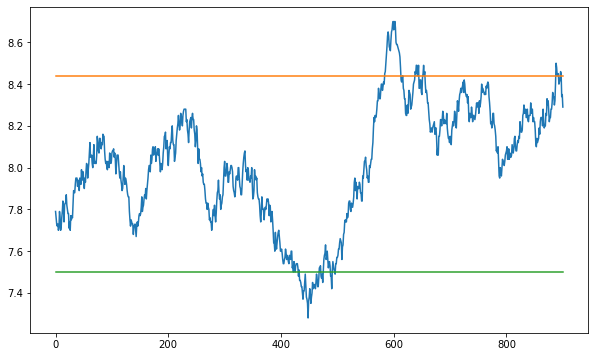

In [10]:
estimated_returns = Qlearn_estimated_returns_function(3000, alpha=0.5, epsilon_decay=0.9995, gamma=0.9, min_epsilon=0.1)
reward_array = return_reward_array(estimated_returns, 1000)
reward_array = np.convolve(reward_array, np.ones(100), mode='valid')
reward_array /= 100

plt.figure(figsize=(10,6))
plt.plot(reward_array)
plt.plot([np.percentile(reward_array, 95)] * len(reward_array))
plt.plot([np.percentile(reward_array, 5)] * len(reward_array))